In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib.lines import Line2D
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) #set figsize for all
sns.set(palette = 'RdBu')
sns.set_style('white')

### Read data and concat

Two sources:
* 1969-1988: Center for Disease Control from Jake Vpd
* 1994-2014: Two sets from FiveThirtyEight
  - Center for Disease Control (1994-2003)
  - Social Security (2004-2014)

In [2]:
# First set
vpd = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv').groupby(['year', 'month', 'day'])['births'].sum().reset_index()
vpd['day'] = vpd['day'].astype(int)
# need to remove a few invalid dates with sigma clipping from Jake VPD's code
quartiles = np.percentile(vpd['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.7413 * (quartiles[2] - quartiles[0])
vpd = vpd.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

# Second set
fte_cdc = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_1994-2003_CDC_NCHS.csv')
fte_ss = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_2000-2014_SSA.csv')
fte = pd.concat([fte_cdc, fte_ss[fte_ss['year'] > 2003]], axis=0) #concat two 538 sets
fte = fte.drop(columns=['day_of_week']).rename(columns = {'date_of_month':'day'}) #rename to get same column names

# Concat
birth_df = pd.concat([vpd, fte], axis=0)

In [3]:
birth_df.head()

,year,month,day,births
0,1969,1,1,8486
1,1969,1,2,9002
2,1969,1,3,9542
3,1969,1,4,8960
4,1969,1,5,8390


### Plot birthdays

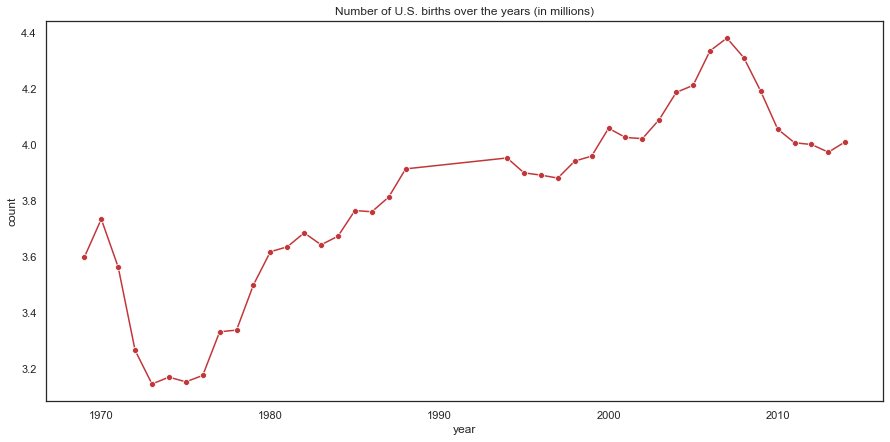

In [4]:
#Plot
data = birth_df.groupby('year')['births'].sum().reset_index(name='count')

ax = sns.lineplot(x=data['year'], y=data['count']/np.power(10, 6), marker='o')
ax.set_title('Number of U.S. births over the years (in millions)')
plt.show()

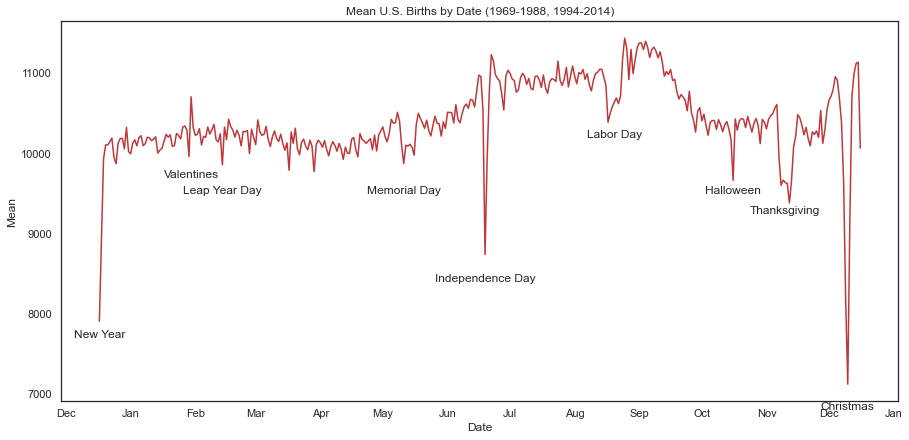

In [5]:
# Get date (pick leap year as placeholder)
birth_df['date'] = pd.to_datetime('2012-'+birth_df['month'].astype(str)+'-'+birth_df['day'].astype(str))
data = birth_df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')

# Plot
ax = sns.lineplot(x=data['date'], y=data['mean'])
ax.set(title='Mean U.S. Births by Date (1969-1988, 1994-2014)', ylabel='Mean', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 1), 7700, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 9700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 9500, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 9500, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 10200, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9500, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 9250, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6800, "Christmas", ha='center')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

In [6]:
data['date'] = data['date'].dt.strftime('%B %d')

print("Top birthdays sorted by mean: ")
(data.sort_values('mean', ascending=False)
    .style
    .format({'mean': '{:20,.0f}'})
    .hide_index()
    .background_gradient(cmap='RdBu'))

Top birthdays sorted by mean: 


date,mean
September 09,"11,435"
September 19,"11,397"
September 16,"11,377"
September 17,"11,375"
September 23,"11,324"
September 20,"11,322"
September 15,"11,318"
September 10,"11,307"
September 12,"11,296"
September 18,"11,293"


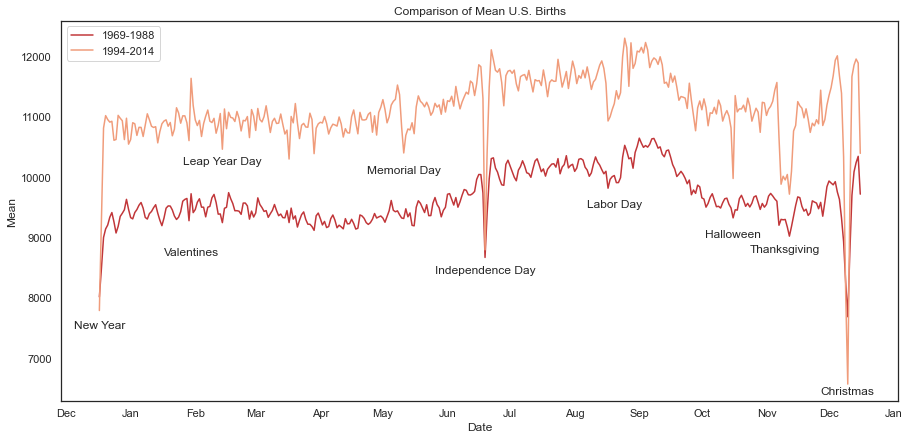

In [7]:
# Has trend changed? Compared the two periods
fig, ax = plt.subplots()

for i, df in enumerate([vpd, fte]):
    df['date'] = pd.to_datetime('2012-'+df['month'].astype(str)+'-'+df['day'].astype(str))
    data = df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')
     
    sns.lineplot(x=data['date'], y=data['mean'], ax=ax)    
    
ax.text(datetime.datetime(2012, 1, 1), 7500, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 8700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 10200, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 10050, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 9500, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9000, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 8750, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6400, "Christmas", ha='center')

ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

ax.set(title='Comparison of Mean U.S. Births', ylabel='Mean', xlabel='Date')
ax.legend(['1969-1988','1994-2014'])
plt.show()

Some biggest differences in the 21st Century:
- More babies are born
- More births on Valentine's
- BIG drops on major holidays: New Year, Memorial, 4th July, Labor, Halloween, Thanksviging, and Christmas -- Americans take holidays more seriously?

### Understand conception periods

#### By pure dates

In [8]:
# Get conceived dates
birth_df['date'] = [datetime.datetime(year, month, day) for (year, month, day) in zip(birth_df['year'], birth_df['month'], birth_df['day'])]
birth_df['conceived_date'] = birth_df['date'] - datetime.timedelta(days=280) #40 weeks
birth_df['dayofweek'] = birth_df['conceived_date'].dt.strftime('%A')

# Group by
birth_df['conceived_date'] = birth_df['conceived_date'].dt.strftime('%b %d')
data = birth_df.groupby(['conceived_date', 'dayofweek'])['births'].mean().reset_index(name='mean')
data.head()

,conceived_date,dayofweek,mean
0,Apr 01,Friday,11167.600000
1,Apr 01,Monday,10225.833333
2,Apr 01,Saturday,8580.000000
3,Apr 01,Sunday,7694.833333
4,Apr 01,Thursday,10891.571429


In [9]:
# Get dummies
for col in ['dayofweek', 'conceived_date']:
    dummy = pd.get_dummies(data[col])
    data = pd.concat([data, dummy], axis=1)

data = data.drop(columns=['conceived_date', 'dayofweek', 'Jan 17', 'Monday']) #drop Jan 17(average), Monday as they are our base
data.head()

,mean,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr 01,Apr 02,Apr 03,...,Sep 21,Sep 22,Sep 23,Sep 24,Sep 25,Sep 26,Sep 27,Sep 28,Sep 29,Sep 30
0,11167.600000,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10225.833333,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8580.000000,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7694.833333,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10891.571429,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
Y = data['mean']
X = data[data.columns[1:]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     99.83
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        13:38:28   Log-Likelihood:                -18657.
No. Observations:                2561   AIC:                         3.806e+04
Df Residuals:                    2189   BIC:                         4.023e+04
Df Model:                         371                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.078e+04    145.444     74.087      0.000    1.05e+04    1.11e+04
Friday       484.6217     28.216     17.176      0.000     429.290     539.954
Saturday   -2124.5234     28.238    -75.236      0.000   -2179.900   -2069.147
Sunday     -2833.3801     28.216   -100.419      0.000   -2888.712   -2778.048
Thursday     516.5407     28.216     18.307      0.000     461.209     571.873
Tuesday      833.8978     28.216     29.555      0.000     778.566     889.230
Wednesday    590.6827     28.216     20.935      0.000     535.351     646.015
Apr 01      -304.4184    204.024     -1.492      0.136    -704.519      95.682
Apr 02      -345.7395    204.024     -1.695      0.090    -745.840      54.361
Apr 03      -464.3367    204.024     -2.276      0.023    -864.437     -64.237
Apr 04      -506.2143    204.024     -2.481      0.013    -906.314    -106.114
Apr 05      -260.8367    204.024     -1.278      0.201    -660.937     139.263
Apr 06      -146.2531    204.024     -0.717      0.474    -546.353     253.847
Apr 07      -174.9558    204.024     -0.858      0.391    -575.056     225.144
Apr 08      -397.9306    204.024     -1.950      0.051    -798.031       2.170
Apr 09      -215.9238    204.024     -1.058      0.290    -616.024     184.176
Apr 10      -400.2558    204.024     -1.962      0.050    -800.356      -0.156
Apr 11      -383.6170    204.024     -1.880      0.060    -783.717      16.483
Apr 12      -257.1605    204.024     -1.260      0.208    -657.261     142.940
Apr 13      -156.7667    204.024     -0.768      0.442    -556.867     243.334
Apr 14      -268.4163    204.024     -1.316      0.188    -668.517     131.684
Apr 15      -256.3136    204.024     -1.256      0.209    -656.414     143.787
Apr 16      -313.6354    204.024     -1.537      0.124    -713.736      86.465
Apr 17      -323.1680    204.024     -1.584      0.113    -723.268      76.932
Apr 18      -253.6245    204.024     -1.243      0.214    -653.725     146.476
Apr 19      -191.5000    204.024     -0.939      0.348    -591.600     208.600
Apr 20      -138.8544    204.024     -0.681      0.496    -538.955     261.246
Apr 21      -212.3109    204.024     -1.041      0.298    -612.411     187.789
Apr 22      -283.5483    204.024     -1.390      0.165    -683.649     116.552
Apr 23      -325.5197    204.024     -1.596      0.111    -725.620      74.580
Apr 24      -414.7667    204.024     -2.033      0.042    -814.867     -14.666
Apr 25      -333.4728    204.024     -1.634      0.102    -733.573      66.627
Apr 26      -326.3864    204.024     -1.600      0.110    -726.487      73.714
Apr 27      -191.1129    204.024     -0.937      0.349    -591.213     208.987
Apr 28      -134.3844    204.024     -0.659      0.510    -534.485     265.716
Apr 29      -256.2483    204.024     -1.256      0.209    -656.349     143.852
Ap

In [11]:
# Print top 15 dates
results_df = pd.DataFrame({'date':results.params.index, 'coefficient':results.params.values,
                          'lower': results.conf_int()[0], 'upper':results.conf_int()[1]})
results_df = results_df[~(results_df['date'].isin(['const', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))]
results_df.sort_values(by='coefficient', ascending=False)[:15]

,date,coefficient,lower,upper
Dec 14,Dec 14,1002.439456,602.339245,1402.539667
Dec 13,Dec 13,975.748299,575.648089,1375.848510
Dec 15,Dec 15,934.748299,534.648089,1334.848510
Dec 12,Dec 12,928.495238,528.395027,1328.595449
Dec 03,Dec 03,915.759864,515.659653,1315.860075
Dec 09,Dec 09,885.754422,485.654211,1285.854633
Dec 10,Dec 10,879.036735,478.936524,1279.136945
Dec 11,Dec 11,868.218367,468.118157,1268.318578
Dec 16,Dec 16,866.640816,466.540606,1266.741027
Dec 20,Dec 20,859.537415,459.437204,1259.637626


/Users/taidnguyen/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


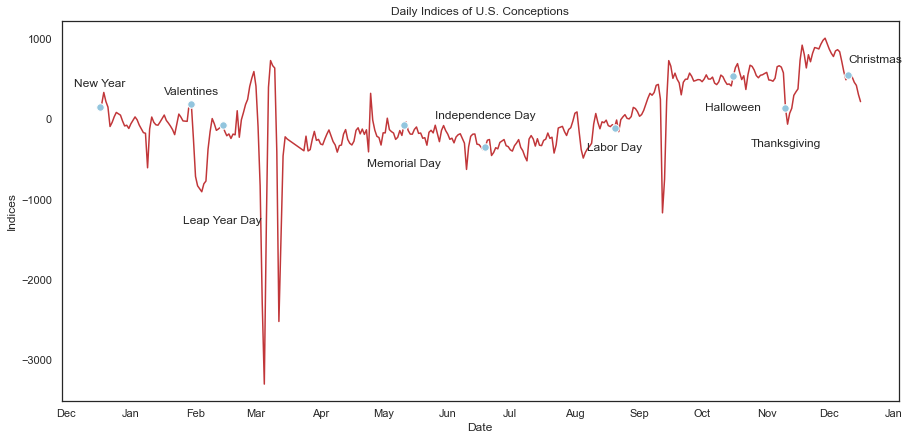

In [12]:
data = results_df[7:]
data['date'] = pd.to_datetime('2012 ' + data['date'], format='%Y %b %d', errors='ignore') #get date (pick leap year as placeholder)


# Plot
ax = sns.lineplot(x=data['date'], y=data['coefficient'])
ax.set(title='Daily Indices of U.S. Conceptions', ylabel='Indices', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 1), 400, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 300, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), -1300, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), -600, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 0, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), -400, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 100, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), -350, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 700, "Christmas", ha='left')
#dots
point_dict = data.set_index('date').to_dict('index')

def add_dot(year, month, day, value):
    ax.plot(datetime.datetime(year, month, day), point_dict[datetime.datetime(year, month, day)][value], 
            marker='.', markersize=15, markeredgecolor='white', color='#92c5de')

add_dot(2012, 1, 1, value='coefficient')
add_dot(2012, 2, 14, value='coefficient')
add_dot(2012, 2, 29, value='coefficient')
add_dot(2012, 5, 26, value='coefficient')
add_dot(2012, 7, 4, value='coefficient')
add_dot(2012, 9, 4, value='coefficient')
add_dot(2012, 10, 31, value='coefficient')
add_dot(2012, 11, 25, value='coefficient')
add_dot(2012, 12, 25, value='coefficient')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

/Users/taidnguyen/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


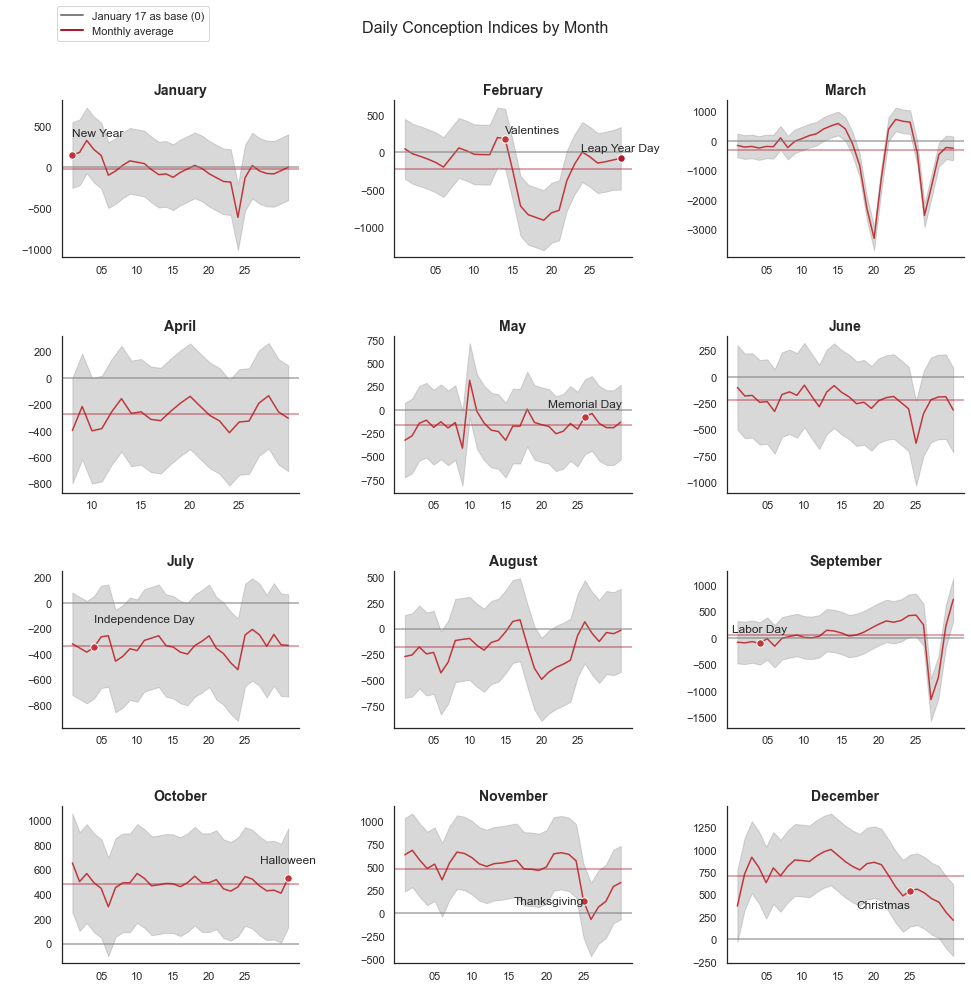

In [13]:
# FacetGrid
data['month'] = data['date'].dt.strftime('%B') 

# Init
g = sns.FacetGrid(data.sort_values(['date']), col='month', col_wrap=3, sharey=False, sharex=False, 
                  height=3.5, aspect=1.3)

# Map lines
def lines(x,y, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    ax.axhline(0, alpha=0.7, color='gray')
    ax.axhline(np.mean(y), alpha=0.5, color='#b2182b')
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
    ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=[0,1,5,10,15,20,25]))
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%d'))
    
g = g.map(lines, 'date', 'coefficient')
g = g.map(plt.fill_between, 'date', 'lower', 'upper', color='gray', alpha=0.3)
g = g.set_titles(col_template="{col_name}", size=14, fontweight='bold')
g = g.set_xlabels(' ')
g = g.set_ylabels(' ')
g = g.set_xticklabels(' ')
 
# Manually add major dates
point_dict = data.set_index('date').to_dict('index') 

g.axes[0].text(datetime.datetime(2012, 1, 1), 380, "New Year", ha='left', fontsize=12)
g.axes[0].plot(datetime.datetime(2012, 1, 1), point_dict[datetime.datetime(2012, 1, 1)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[1].text(datetime.datetime(2012, 2, 14), 250, "Valentines", ha='left', fontsize=12)
g.axes[1].plot(datetime.datetime(2012, 2, 14), point_dict[datetime.datetime(2012, 2, 14)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[1].text(datetime.datetime(2012, 2, 29), 20, "Leap Year Day", ha='center', fontsize=12)
g.axes[1].plot(datetime.datetime(2012, 2, 29), point_dict[datetime.datetime(2012, 2, 29)]['coefficient'], marker='.', markersize=15, markeredgecolor='white', color='#b2182b')
g.axes[4].text(datetime.datetime(2012, 5, 26), 25, "Memorial Day", ha='center', fontsize=12)
g.axes[4].plot(datetime.datetime(2012, 5, 26), point_dict[datetime.datetime(2012, 5, 26)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[6].text(datetime.datetime(2012, 7, 4), -150, "Independence Day", ha='left', fontsize=12)
g.axes[6].plot(datetime.datetime(2012, 7, 4), point_dict[datetime.datetime(2012, 7, 4)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[8].text(datetime.datetime(2012, 9, 4), 100, "Labor Day", ha='center', fontsize=12)
g.axes[8].plot(datetime.datetime(2012, 9, 4), point_dict[datetime.datetime(2012, 9, 4)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[9].text(datetime.datetime(2012, 10, 31), 650, "Halloween", ha='center', fontsize=12)
g.axes[9].plot(datetime.datetime(2012, 10, 31), point_dict[datetime.datetime(2012, 10, 31)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[10].text(datetime.datetime(2012, 11, 25), 100, "Thanksgiving", ha='right', fontsize=12)
g.axes[10].plot(datetime.datetime(2012, 11, 25), point_dict[datetime.datetime(2012, 11, 25)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[11].text(datetime.datetime(2012, 12, 25), 350, "Christmas", ha='right', fontsize=12)
g.axes[11].plot(datetime.datetime(2012, 12, 25), point_dict[datetime.datetime(2012, 12, 25)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')

# # Legends
custom_lines = [Line2D([0], [0], color='gray', lw=2),
                Line2D([0], [0], color='#b2182b', lw=2)]
g.axes[0].legend(custom_lines, ['January 17 as base (0)', 'Monthly average'],
          loc='upper center', bbox_to_anchor=(0.3, 1.6), borderaxespad=0.)

# Final adjustments
plt.subplots_adjust(hspace=0.5, wspace=0.4, top=0.9) #spacing between and on top
g = g.fig.suptitle('Daily Conception Indices by Month', fontsize=16)
plt.show()

#### By two-week periods

In [14]:
# Get conceived dates
birth_df['conceived_start'] = birth_df['date'] - datetime.timedelta(days=280) #40 weeks
birth_df['conceived_end'] = birth_df['date'] - datetime.timedelta(days=266) #38 weeks
birth_df.head()

,year,month,day,births,date,conceived_date,dayofweek,conceived_start,conceived_end
0,1969,1,1,8486,1969-01-01,Mar 27,Wednesday,1968-03-27,1968-04-10
1,1969,1,2,9002,1969-01-02,Mar 28,Thursday,1968-03-28,1968-04-11
2,1969,1,3,9542,1969-01-03,Mar 29,Friday,1968-03-29,1968-04-12
3,1969,1,4,8960,1969-01-04,Mar 30,Saturday,1968-03-30,1968-04-13
4,1969,1,5,8390,1969-01-05,Mar 31,Sunday,1968-03-31,1968-04-14


In [15]:
birth_df['conceived_start'] = birth_df['conceived_start'].dt.strftime('%B %d')
birth_df['conceived_end'] = birth_df['conceived_end'].dt.strftime('%B %d')

data = birth_df.groupby(['conceived_start', 'conceived_end'])['births'].mean().reset_index(name='mean')

In [16]:
data.sort_values('mean', ascending=False)[:20]

,conceived_start,conceived_end,mean
63,December 03,December 17,11473.146341
70,December 10,December 24,11426.536585
73,December 13,December 27,11352.756098
77,December 17,December 31,11351.414634
69,December 09,December 23,11339.365854
76,December 16,December 30,11317.829268
74,December 14,December 28,11314.268293
75,December 15,December 29,11296.219512
72,December 12,December 26,11289.682927
71,December 11,December 25,11280.756098
